<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-the-squared-composer" data-toc-modified-id="Create-the-squared-composer-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create the squared composer</a></span></li><li><span><a href="#Calculate-variance" data-toc-modified-id="Calculate-variance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate variance</a></span><ul class="toc-item"><li><span><a href="#Demo-of-subgraph-of-two-edges" data-toc-modified-id="Demo-of-subgraph-of-two-edges-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Demo of subgraph of two edges</a></span></li><li><span><a href="#Manual-computation-of-cost-distribution" data-toc-modified-id="Manual-computation-of-cost-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Manual computation of cost distribution</a></span></li></ul></li><li><span><a href="#Large-scale-simulations" data-toc-modified-id="Large-scale-simulations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Large scale simulations</a></span><ul class="toc-item"><li><span><a href="#Calculate-the-width" data-toc-modified-id="Calculate-the-width-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Calculate the width</a></span></li></ul></li></ul></div>

# Calculating variance of energy using tensor networks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qtensor
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm.auto import tqdm
from qtensor import QtreeQAOAComposer

import xarray
from cartesian_explorer import parallels, dict_product # for large-scale parallel simualtions

## Create the squared composer

In [3]:
def get_edge_subgraph_squared(G, edge1, edge2, dist):
    nodes_groups = qtensor.utils.nodes_group_by_distance(G, edge1+edge2, dist)
    all_nodes = sum(nodes_groups.values(), [])
    subgraph = G.subgraph(all_nodes).copy()
    farthest_nodes = nodes_groups[dist]
    
    edges_to_delete = []
    for u, v in subgraph.edges():
        if (u in farthest_nodes) and (v in farthest_nodes):
            edges_to_delete.append((u,v))
    subgraph.remove_edges_from(edges_to_delete)
    return subgraph

class QAOAComposerSquared(QtreeQAOAComposer):
    def cone_ansatz_squared(self, edge1, edge2):
        beta, gamma = self.params['beta'], self.params['gamma']
        
        assert(len(beta) == len(gamma))
        p = len(beta) # infering number of QAOA steps from the parameters passed
        self.layer_of_Hadamards()
        # second, apply p alternating operators
        cone_base = self.graph

        for i, g, b in zip(range(p, 0, -1), gamma, beta):
            self.graph = get_edge_subgraph_squared(cone_base, edge1, edge2, i)
            self.cost_operator_circuit(g)
            self.graph = get_edge_subgraph_squared(cone_base, edge1, edge2, i-1)
            self.mixer_operator(b)
        self.graph = cone_base


    def energy_expectation_squared(self, edge1, edge2):
        # Will need to deprecate stateful API and return the circuit
        self.cone_ansatz_squared(edge1, edge2)
        self.energy_edge(*edge1)
        self.energy_edge(*edge2)
        first_part = self.builder.circuit
        self.builder.reset()

        self.cone_ansatz_squared(edge1, edge2)
        self.builder.inverse()
        second_part = self.builder.circuit

        self.circuit = first_part + second_part
    
    def energy_expectation_lightcone_squared(self, edge1, edge2):
        G = self.graph
        gamma, beta = self.params['gamma'], self.params['beta']
        graph = get_edge_subgraph_squared(G, edge1, edge2, len(gamma))
        #print('Subgraph nodes: {}, edges: {}', graph.number_of_nodes(), graph.number_of_edges())
        self.n_qubits = graph.number_of_nodes()
        mapping = {v:i for i, v in enumerate(graph.nodes())}
        graph = nx.relabel_nodes(graph, mapping, copy=True)

        edge1 = mapping[edge1[0]], mapping[edge1[1]]
        edge2 = mapping[edge2[0]], mapping[edge2[1]]
        composer = self._get_of_my_type(graph, beta=beta, gamma=gamma)
        composer.energy_expectation_squared(edge1, edge2)
        self.circuit = composer.circuit
        # return composer


In [4]:
#Test for runtime errrors in composer
G = nx.random_regular_graph(3, 12, seed=12)
p = 2
edges = list(G.edges())
comp = QAOAComposerSquared(G, gamma=[0.1]*p, beta=[0.2]*p)
edge_pair = edges[0], edges[2]
comp.energy_expectation_lightcone_squared(*edge_pair)

In [5]:
def get_gb(p):
    gammabeta = np.array(qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'])/np.pi
    return gammabeta[:p], gammabeta[p:]
    
def get_maxcut_probs(G, p, backend=qtensor.NumpyBackend()):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, backend=backend)
    gamma, beta = get_gb(p)
    comp = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
    comp.ansatz_state()
    circ = comp.circuit
    sim.optimizer = qtensor.toolbox.get_ordering_algo('naive')
    amps = sim.simulate_batch(circ, batch_vars=range(G.number_of_nodes()))
    probs = np.real(amps.conj()*amps)
    return probs

def get_maxcut_cost_dist(G, p=6):
    N = G.number_of_nodes()
    probs = get_maxcut_probs(G, p)
    print('got probs')
    bitst = np.array(np.unravel_index(range(2**N), shape=[2]*N))*2-1
    e = G.number_of_edges()
    costs = [(e-sum(sol[i]*sol[j] for i,j in G.edges))/2 for sol in bitst.T]
    costs = np.array(costs)
    print('got costs')
    distr = dict()
    for i in range(len(probs)):
        c = costs[i]
        distr.setdefault(c, 0)
        distr[c] += probs[i]
    return distr

## Calculate variance

In [6]:
G = nx.random_regular_graph(3, 18, seed=12)
p = 2
edge_pair = edges[0], edges[2]

In [7]:
subgraph = get_edge_subgraph_squared(G, *edge_pair, p)

### Demo of subgraph of two edges

Text(0.5, 1.0, 'Subgraph on ((4, 10), (4, 7))')

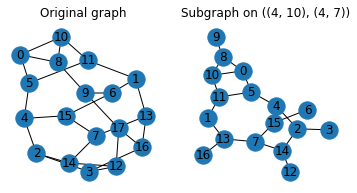

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))
plt.sca(axs[0])
nx.draw_kamada_kawai(G, with_labels=True)
plt.title(f'Original graph')
plt.sca(axs[1])
nx.draw_kamada_kawai(subgraph, with_labels=True)
plt.title(f'Subgraph on {edge_pair}')

### Manual computation of cost distribution

got probs
got costs


Text(0.5, 1.0, 'Cost distribution')

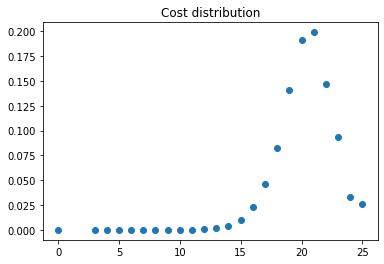

In [9]:
assert G.number_of_nodes()<20, "Too many nodes"
cost_dist = get_maxcut_cost_dist(G, p=p)
cost_dist

plt.scatter(cost_dist.keys(), cost_dist.values())
plt.title('Cost distribution')

In [10]:
def post_process_variance(E, linear, squared):
    cost = 1/2*(E - linear)
    cost2 = 1/4*(E*E - 2*E*linear + squared)
    return cost, cost2

def simulate_variance(G, p=4, pbar=True):
    gamma, beta = get_gb(p)
    sim = qtensor.QtreeSimulator()
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    squared = 0
    if pbar:
        outer_loop = tqdm(list(G.edges))
    else:
        outer_loop = G.edges
    for e1 in outer_loop:
        for e2 in G.edges:
            comp.energy_expectation_lightcone_squared(e1, e2)
            energy2 = sim.simulate_batch(comp.circuit, batch_vars=0)
            squared += energy2
    linear = 0
    for e in G.edges:
            comp.energy_expectation_lightcone(e)
            energy = sim.simulate_batch(comp.circuit, batch_vars=0)
            linear += energy
    E = G.number_of_edges()
    cost, cost2 = post_process_variance(E, linear, squared)
    print('linear', linear)
    print('squared', squared)
    print('cost', cost)
    print('cost2', cost2)
    return cost2 - cost*cost


In [11]:
var = simulate_variance(G, p=p)
print('Variance', var)

  0%|          | 0/27 [00:00<?, ?it/s]

linear [-13.8105975-1.47544863e-16j]
squared [208.53967912+3.49732139e-15j]
cost [20.40529875+7.37724315e-17j]
cost2 [420.82798602+2.866186e-15j]
Variance [4.45176896-1.4451101e-16j]


In [12]:
pdf = np.array(list(cost_dist.values()))
x = np.array(list(cost_dist.keys()))
Z = sum(pdf)
mean = sum(pdf*x)/Z
var_direct = sum(pdf*(mean-x)**2)/Z
var_direct

4.451755159826651

In [14]:
assert np.isclose(np.real(var), var_direct), "The two don't match!"
print("The two match!")

The two match!


## Large scale simulations

In [15]:
def circ2tw(circ, opt: qtensor.optimisation.Optimizer):
    tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(circ)
    opt.optimize(tn)
    return opt.treewidth
    
def estimate_variance_tw(G, p=4, ordering_algo='greedy', pbar=False):
    gamma, beta = get_gb(p)
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    widths = []
    if pbar:
        outer_loop = tqdm(list(G.edges))
    else:
        outer_loop = G.edges
    for e1 in outer_loop:
        for e2 in G.edges:
            comp.energy_expectation_lightcone_squared(e1, e2)
            tw = circ2tw(comp.circuit, opt)
            widths.append(tw)
    return widths

In [19]:
widths = estimate_variance_tw(G, p=p, pbar=True)

  0%|          | 0/27 [00:00<?, ?it/s]

Max width 19


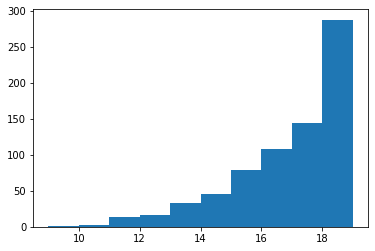

In [20]:
plt.hist(widths)
print("Max width", max(widths))

In [16]:
parallel = parallels.Ray(processes=55)

In [37]:
Ns = [20, 30, 40]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit(N, p):
    G = nx.random_regular_graph(3, N, seed=10)
    return estimate_variance_tw(G, p=p)
args = dict_product(**params)

In [38]:
data = parallel.starstarmap(unit, args)

In [17]:
# parallelism at the level of individual graph

# -- Treewidth
def tw_parallel_unit(G, p, e1, ordering_algo='greedy'):
    gamma, beta = get_gb(p)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    widths = []
    for e2 in G.edges:
        comp.energy_expectation_lightcone_squared(e1, e2)
        tw = circ2tw(comp.circuit, opt)
        widths.append(tw)
    return widths
    
def estimate_variance_tw_parallel(G, parallel, p=4, ordering_algo='greedy'):
    args = dict_product(e1=list(G.edges), p=[p], G=[G], ordering_algo=[ordering_algo])
    widths_sq = parallel.starstarmap(tw_parallel_unit, args)
    return sum(widths_sq, [])

# -- Simulation
def variance_parallel_unit(G, p, e1, ordering_algo='greedy'):
    gamma, beta = get_gb(p)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    sim = qtensor.QtreeSimulator(optimizer=opt)
    squared = 0
    for e2 in G.edges:
        comp.energy_expectation_lightcone_squared(e1, e2)
        energy2 = sim.simulate_batch(comp.circuit, batch_vars=0)
        squared += energy2
    return squared

    
def simulate_variance_parallel(G, parallel, p=4, ordering_algo='greedy'):
    args = dict_product(e1=list(G.edges), p=[p], G=[G], ordering_algo=[ordering_algo])
    squared_seq = parallel.starstarmap(variance_parallel_unit, args)
    squared = np.array(squared_seq).sum()

    # -- linear
    gamma, beta = get_gb(p)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    sim = qtensor.QtreeSimulator()
    linear = 0
    # this is usually much faster, so don't bother
    for e in G.edges:
        comp.energy_expectation_lightcone(e)
        energy = sim.simulate_batch(comp.circuit, batch_vars=0)
        linear += energy
    # -- linear
    E = G.number_of_edges()
    cost, cost2 = post_process_variance(E, linear, squared)
    return cost2 - cost*cost

In [84]:
widths = estimate_variance_tw_parallel(G, parallel, p=p)
var = simulate_variance_parallel(G, parallel, p=p)
var

array([4.45176896-1.4451101e-16j])

(array([  7.,  22.,  82., 130., 188., 162.,  84.,  26.,  22.,   6.]),
 array([ 6. ,  6.9,  7.8,  8.7,  9.6, 10.5, 11.4, 12.3, 13.2, 14.1, 15. ]),
 <BarContainer object of 10 artists>)

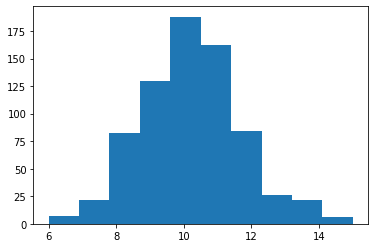

In [85]:
plt.hist(widths)

In [29]:
Ns = [20, 30, 40, 50]
ps = [2, 3, 4]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=10)
    return estimate_variance_tw_parallel(G, parallel, p=p)
args = dict_product(**params)

In [31]:
data = parallel.starstarmap(unit_parallel, args)

In [35]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys())
xwm = xarray.apply_ufunc(max, xwa, vectorize=True)

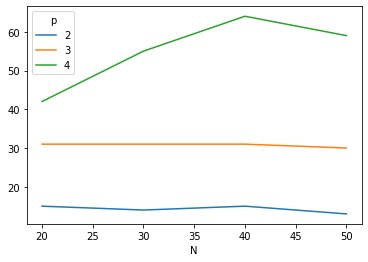

In [36]:
xwm.plot(x='N', hue='p')

In [ ]:
## ordering algo

In [39]:
Ns = [20, 30, 40, 50]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=10)
    return estimate_variance_tw_parallel(G, parallel, p=p, ordering_algo=ing_algo='rgreedy_0.03_10')
args = dict_product(**params)

In [40]:
data = parallel.starstarmap(unit_parallel, args)

In [41]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys())
xwm = xarray.apply_ufunc(max, xwa, vectorize=True)

/tmp/ipykernel_79058/4048087232.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data).reshape(len(params['N']), -1)


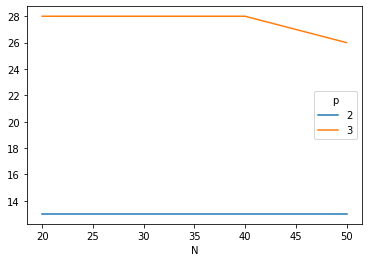

In [42]:
xwm.plot(x='N', hue='p')

### Calculate the width

In [98]:
Ns = [18, 20, 22, 24, 26, 28, 30, 36, 40, 46, 54]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=11)
    return simulate_variance_parallel(G, parallel, p=p, ordering_algo='rgreedy_0.03_10')
args = dict_product(**params)

In [99]:
data = parallel.starstarmap(unit_parallel, args)

In [100]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys()).real
xwr = xwa/xwa.N/3*2

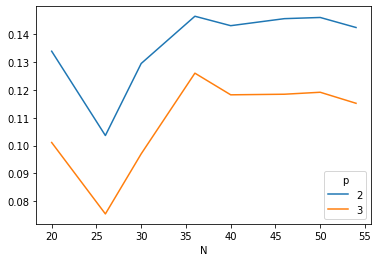

In [101]:
xwr.plot(x='N', hue='p')

In [ ]:
## large N

In [18]:
Ns = [256]#, 512, 1024]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=11)
    return simulate_variance_parallel(G, parallel, p=p, ordering_algo='rgreedy_0.03_10')
args = dict_product(**params)

In [ ]:
data = parallel.starstarmap(unit_parallel, args)

In [ ]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys()).real
xwr = xwa/xwa.N/3*2

In [ ]:
xwr.plot(x='N', hue='p')

---